<a href="https://colab.research.google.com/github/absolution-end/Deep-learning-using-pytorch/blob/main/tabular_classification_ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
!pip install torch
!pip install torchvision
!pip install torchaudio

In [46]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Skipping, found downloaded files in "./rice-type-classification" (use force=True to force download)


In [67]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split # (train, validation, test)
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [68]:
data_df = pd.read_csv("/content/rice-type-classification/riceClassification.csv")
data_df.dropna(inplace=True)
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [69]:
data_df.drop("id",axis=1,inplace=True)
data_df

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1
...,...,...,...,...,...,...,...,...,...,...,...
18180,5853,148.624571,51.029281,0.939210,6008,86.326537,0.498594,332.960,0.663444,2.912535,0
18181,7585,169.593996,58.141659,0.939398,7806,98.272692,0.647461,385.506,0.641362,2.916910,0
18182,6365,154.777085,52.908085,0.939760,6531,90.023162,0.561287,342.253,0.682832,2.925396,0
18183,5960,151.397924,51.474600,0.940427,6189,87.112041,0.492399,343.371,0.635227,2.941216,0


In [70]:
print(data_df["Class"].unique())

[1 0]


In [71]:
print(data_df["Class"].value_counts())

Class
1    9985
0    8200
Name: count, dtype: int64


In [72]:
# Normalized
original_df = data_df.copy()

for column in data_df.columns:
  data_df[column] = data_df[column]/data_df[column].abs().max()
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [73]:
# [row, columns]
x = np.array(data_df.iloc[:,:-1])
y = np.array(data_df.iloc[:,-1])

In [74]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state=42)

In [75]:
x_train, x_valid, y_train, y_valid = train_test_split(x_test,y_test,test_size=0.5)

In [76]:
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)

(2728, 10)
(2728, 10)
(5456, 10)


In [77]:
class dataset(Dataset):
  def __init__(self,x ,y):
    self.x = torch.tensor(x, dtype=torch.float32)
    self.y = torch.tensor(y, dtype=torch.float32)

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    return self.x[index], self.y[index]

training_data = dataset(x_train, y_train)
validation_data = dataset(x_valid, y_valid)
testing_data = dataset(x_test, y_test)

In [78]:
BATCH_SIZE = 32
EPOCHS = 10
HIDDEN_NEURONS = 10
LR = 1e-3

In [79]:
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle= True)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle= True)
testing_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle= True)

In [80]:
HIdden_layer = 10
class MyModule(nn.Module):
  def __init__(self):
    super(MyModule,self).__init__()

    self.input_layer = nn.Linear(x_train.shape[1], HIdden_layer)
    self.linear = nn.Linear(HIdden_layer, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self,x):
    x = self.input_layer(x)
    output = self.linear(x)
    output = self.sigmoid(output)
    return output

model = MyModule().to(device)

In [81]:
summary(model, (x_train.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [82]:
critrion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=1e-3)

In [83]:
total_loss_train_plot=[]
total_loss_valid_plot=[]
total_acc_train_plot=[]
total_acc_valid_plot=[]

for epoch in range(10):
  total_acc_train = 0
  total_loss_train = 0
  total_acc_val = 0
  total_loss_val = 0

  # training and validation
  for data in train_dataloader:
    input, label = data
    prediction = model(input).squeeze(1)
    loss  = critrion(prediction, label)

    total_loss_train += loss.item()
    acc = ((prediction).round()==label).sum().item()

    total_acc_train += acc

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()


  with torch.no_grad():
    for data in validation_dataloader:
      input, label = data

      prediction = model(input).squeeze(1)
      loss = critrion(prediction, label)

      total_loss_val += loss.item()
      acc = ((prediction).round()==label).sum().item()

      total_acc_val += acc

      total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_valid_plot.append(round(total_loss_val/1000, 4))
    total_acc_train_plot.append(round(total_acc_train/(training_data.__len__())*100, 4))
    total_acc_valid_plot.append(round(total_acc_val/(validation_data.__len__())*100, 4))

    print(f'''Epoch no. {epoch + 1} Train Loss: {total_loss_train/1000:.4f}
    Train Accuracy: {(total_acc_train/(training_data.__len__())*100):.4f}
    Validation Loss: {total_loss_val/1000:.4f}
    Validation Accuracy: {(total_acc_val/(validation_data.__len__())*100):.4f}''')
    print("="*50)


Epoch no. 1 Train Loss: 0.0580 
    Train Accuracy: 56.5982 
    Validation Loss: 0.0569 
    Validation Accuracy: 53.9589
Epoch no. 2 Train Loss: 0.0550 
    Train Accuracy: 66.3490 
    Validation Loss: 0.0533 
    Validation Accuracy: 92.0088
Epoch no. 3 Train Loss: 0.0508 
    Train Accuracy: 87.3167 
    Validation Loss: 0.0483 
    Validation Accuracy: 91.8988
Epoch no. 4 Train Loss: 0.0449 
    Train Accuracy: 95.3812 
    Validation Loss: 0.0418 
    Validation Accuracy: 95.8944
Epoch no. 5 Train Loss: 0.0385 
    Train Accuracy: 96.9941 
    Validation Loss: 0.0350 
    Validation Accuracy: 97.5440
Epoch no. 6 Train Loss: 0.0319 
    Train Accuracy: 97.8006 
    Validation Loss: 0.0287 
    Validation Accuracy: 98.1672
Epoch no. 7 Train Loss: 0.0262 
    Train Accuracy: 98.0572 
    Validation Loss: 0.0237 
    Validation Accuracy: 97.8739
Epoch no. 8 Train Loss: 0.0216 
    Train Accuracy: 98.0572 
    Validation Loss: 0.0196 
    Validation Accuracy: 98.5337
Epoch no. 9 Trai

In [84]:
# testing
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for image , label in (testing_dataloader):
    prediction = model(image).squeeze(1)

    loss = critrion(prediction, label)
    total_loss_test += loss.item()

    acc = (prediction.round()==label).sum().item()
    total_acc_test += acc
print(f"Accuracy Score is: {(total_acc_test/x_test.shape[0])*100:.2f}%")

Accuracy Score is: 98.41%


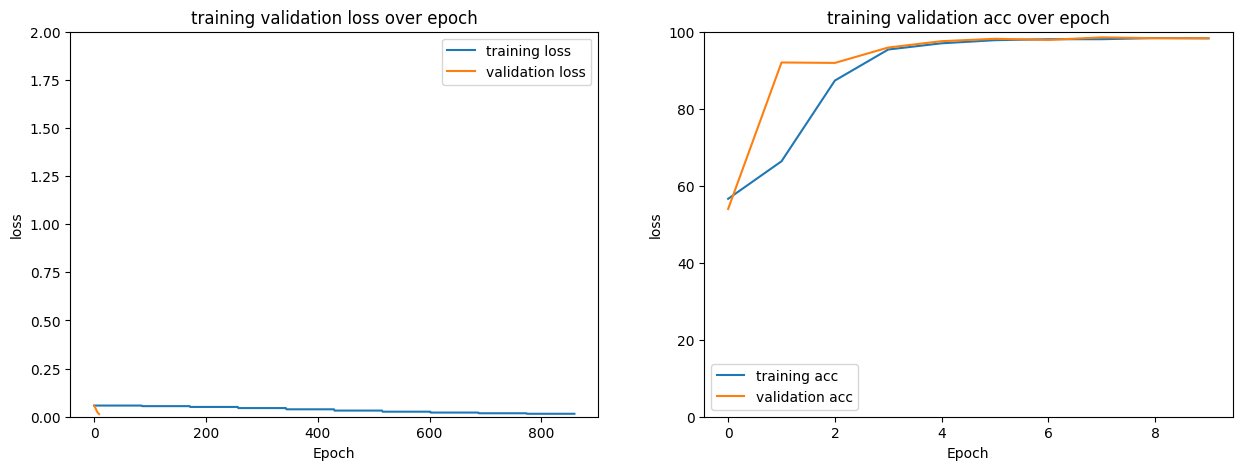

In [89]:
fig , axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axs[0].plot(total_loss_train_plot, label = "training loss")
axs[0].plot(total_loss_valid_plot, label = "validation loss")
axs[0].set_title("training validation loss over epoch")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("loss")
axs[0].set_ylim([0,2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = "training acc")
axs[1].plot(total_acc_valid_plot, label = "validation acc")
axs[1].set_title("training validation acc over epoch")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("loss")
axs[1].set_ylim([0,100])
axs[1].legend()

plt.show()